In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

Файл *dataframe.pickle* является результатом выполнения *preprocessing.ipynb*.

In [2]:
df = pd.read_pickle("./dataframe.pickle")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4395 entries, 0 to 4394
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           4395 non-null   int64         
 1   gender                       4384 non-null   object        
 2   birthdate                    4372 non-null   datetime64[ns]
 3   subject                      4365 non-null   object        
 4   locality                     4364 non-null   object        
 5   disability_group             4268 non-null   object        
 6   disability_cause             4141 non-null   object        
 7   sight_loss_etiology          4395 non-null   object        
 8   sight_loss_age               2159 non-null   float64       
 9   sight_condition              4305 non-null   object        
 10  sight_loss_cause             4063 non-null   object        
 11  hearing_loss_etiology        4395 non-null 

In [4]:
from datetime import date
today = date.today()

df["age_now"] = today.year - df["birthdate"].dt.year
df["recording_year"] = df["recording_date"].dt.year
df["age_recording_year"] = df["recording_year"] - df["birthdate"].dt.year
df["birth_year"] = df["birthdate"].dt.year
df.groupby("recording_year").agg({"age_recording_year":np.mean})

,age_recording_year
recording_year,
2014,40.190476
2015,56.603664
2016,45.615385
2017,43.182243
2018,35.626543
2019,32.643564
2020,41.285714
2021,30.520000
2022,49.000000


In [5]:
# g = sns.catplot(data=df, x=recording_years, y=mean_recording_year, kind="bar")

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def kmeans_clusters(corpus, n):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform(corpus)
    kmeans = KMeans(n_clusters=n).fit(tfidf_matrix)
    return kmeans.predict(vectorizer.transform(corpus))

#     terms = vectorizer.get_feature_names_out()
#     new_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
#     kmeans.cluster_centers_

In [7]:
def find_clusters(column_name, n):
    corpus = df[column_name].dropna()
    clusters = kmeans_clusters(corpus, n)
    return pd.DataFrame(data={column_name:corpus, "cluster":clusters})

In [8]:
sight_condition_clusters = find_clusters("sight_condition", 6)

In [38]:
clusters_name = {
    0:"тотальная слепота",
    1:"слабовидение",
    2:"практическая слепота",
    3:"миопия",
    4:"требует диагностики",
    5:"косоглазие, астигматизм",
}

In [39]:
sight_condition_clusters_name = sight_condition_clusters.replace({"cluster":clusters_name})
sight_condition_clusters_name = pd.concat([sight_condition_clusters_name, df["age_recording_year"], df["gender"]], axis=1).dropna().astype({"age_recording_year":np.uint8})
sight_condition_clusters_name

,sight_condition,cluster,age_recording_year,gender
0,тотальная слепота (без светоощущения),тотальная слепота,29,Женский
1,слабовидение (предметное зрение),слабовидение,38,Мужской
2,"практическая слепота (светоощущение, силуэтное...",практическая слепота,1,Мужской
3,Вижу. Я только глухой,миопия,28,Мужской
4,"практическая слепота (светоощущение, силуэтное...",практическая слепота,41,Женский
...,...,...,...,...
4389,"практическая слепота (светоощущение, силуэтное...",практическая слепота,20,Мужской
4390,слабовидение (предметное зрение),слабовидение,26,Мужской
4392,"практическая слепота (светоощущение, силуэтное...",практическая слепота,8,Женский
4393,"практическая слепота (светоощущение, силуэтное...",практическая слепота,63,Женский


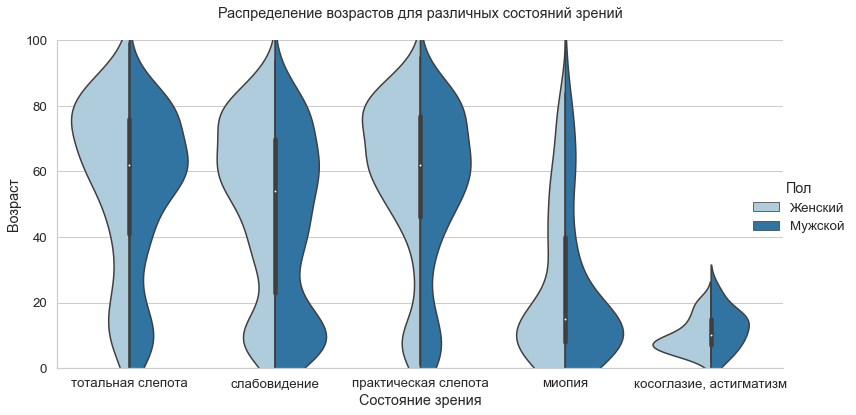

In [95]:
sns.set(font_scale=1.2)
sns.set_palette("Paired")
sns.set_style("whitegrid")
g = sns.catplot(data=sight_condition_clusters_name[sight_condition_clusters_name["cluster"]!="требует диагностики"],
            x="cluster", y="age_recording_year", kind="violin", hue="gender", split=True,
            height=4, aspect=6,
            facet_kws={'legend_out': True})
g.set(ylim=(0, 100))
g.set_axis_labels("Состояние зрения", "Возраст")
g._legend.set_title("Пол")
g.set(title="Распределение возрастов для различных состояний зрений\n")
g.figure.set_size_inches(12, 6, forward=False)
g.tight_layout()